<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


# Registration of an Image Stack
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/Register_Image_Stack.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/Register_Image_Stack.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into registration of an image stack.

This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.8.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade
    
if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
    !{sys.executable} -m pip install simpleitk
# ------------------------------
print('done')

done


**In Google Colab: Please restart runtime Ctrl+M**

### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [1]:
import sys
sys.path.insert(0, '../../../SciFiReaders')

import SciFiReaders
SciFiReaders.__version__


You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


'0.0.11'

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../..')
%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.probe_tools

import skimage

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    
# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2023_1_20'

Symmetry functions of spglib enabled
pyTEM version:  0.2023.8.1


## Open File

### Choose Mode of  File Selection


The FileWidget will use display the name of a Nion File like in NionSwift. 

Select a main dataset and any additional data like reference data and such.

In [3]:
fileWidget = ft.FileWidget()

### Load File

If you did not choose the file widget a File Dialog window will open in the next code cell.

Otherewise just select a File in the widget above

These datasets are stored in the pyNSID data format (extension: hf5) automatically. 

All results can be stored in that file. 

sidpy.Dataset of type IMAGE with:
 dask.array<array, shape=(122, 134), dtype=float32, chunksize=(122, 134), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
x:  distance (nm) of size (122,)
y:  distance (nm) of size (134,)
 with metadata: ['experiment', 'filename']

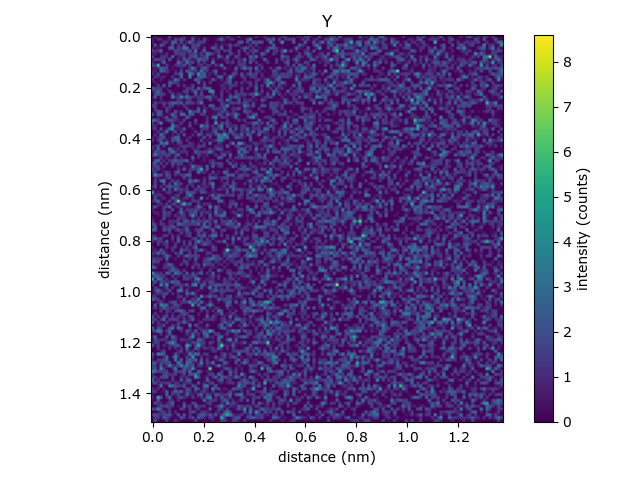

In [4]:
datasets = fileWidget.datasets
dataset = datasets['Channel_000']


view = dataset.plot()
dataset

In [5]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: Y', 'Channel_001: Lu', 'Channel_002: Gd', 'Chan…

We really would need an HAADF image


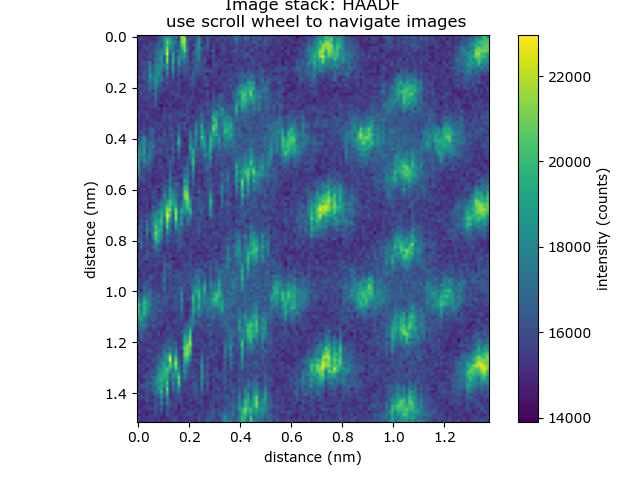

In [6]:
dataset =  chooser.dataset
if dataset.data_type.name != 'IMAGE':
    print('We really would need an HAADF image')

view = chooser.dataset.plot()

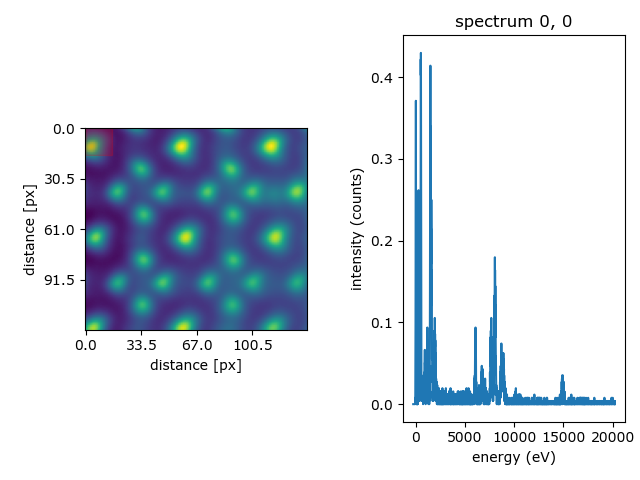

In [7]:
eds = datasets['Channel_004']+datasets['Channel_005']+datasets['Channel_006']+datasets['Channel_007']


#eds.set_bin([10,10])
view = eds.plot()
eds.view.set_bin([16,16])
eds.view.axes[0].imshow(dataset.sum(axis=0))

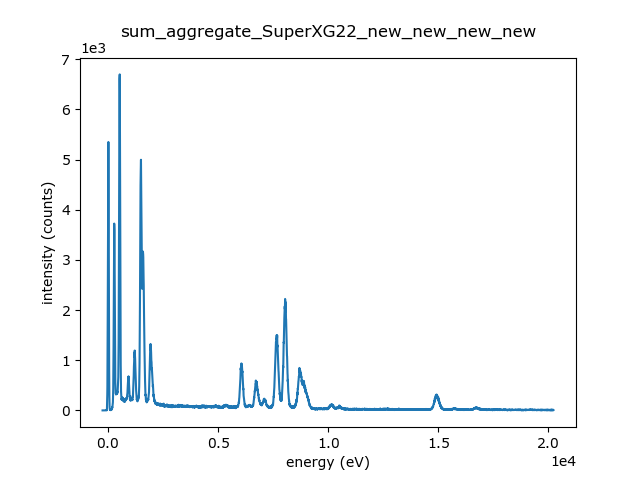

In [233]:
spectrum = eds [:,:,:].sum(axis=[0,1])
spectrum.data_type='spectrum'
view = spectrum.plot()

24


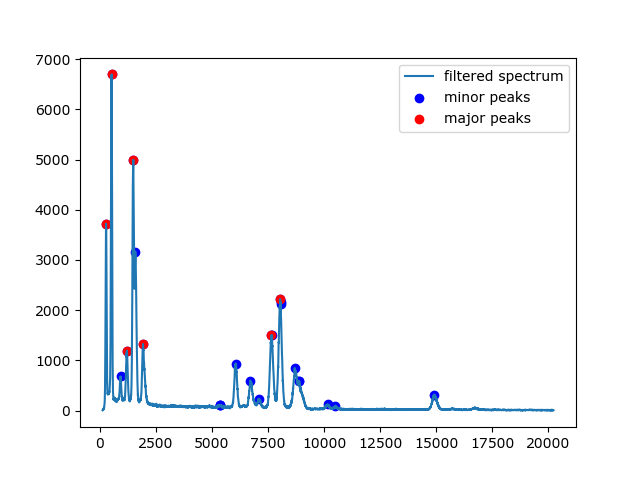

In [256]:
import scipy as sp 
import scipy.signal as sig

energy_scale = spectrum.energy_scale
start = np.searchsorted(energy_scale, 125)
## we use half the width of the resolution for smearing
width = int(np.ceil(125*1e-3/2 /(energy_scale[1]-energy_scale[0])/2)*2+1)
new_spectrum =  scipy.signal.savgol_filter(spectrum[start:], width, 2) ## we use half the width of the resolution for smearing
new_energy_scale = energy_scale[start:]
major_peaks, _  = scipy.signal.find_peaks(new_spectrum, prominence=1000)
prominence = 10
minor_peaks, _  = scipy.signal.find_peaks(new_spectrum, prominence=prominence) 
while len(minor_peaks) > 30: 
    prominence += 10
    minor_peaks, _  = scipy.signal.find_peaks(new_spectrum, prominence=prominence)  
peaks = major_peaks
print(len(minor_peaks))
plt.figure()
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum')
plt.scatter( new_energy_scale[minor_peaks], new_spectrum[minor_peaks], color = 'blue', label='minor peaks')
plt.scatter( new_energy_scale[major_peaks], new_spectrum[major_peaks], color = 'red', label='major peaks')
plt.legend()
#plt.xlim(.126,5);

{}
{'K-L2': {'weight': 0.5, 'position': 183.3}}
{'K-L2': {'weight': 0.5, 'position': 277.40000000000003}}
{'K-L3': {'weight': 1.0, 'position': 392.40000000000003}, 'K-L2': {'weight': 0.5, 'position': 392.40000000000003}}
{'K-L3': {'weight': 1.0, 'position': 524.9}, 'K-L2': {'weight': 0.5, 'position': 524.9}}
{'K-L3': {'weight': 1.0, 'position': 676.8}, 'K-L2': {'weight': 0.5, 'position': 676.8}}
{'K-L3': {'weight': 1.0, 'position': 848.6}, 'K-L2': {'weight': 0.5, 'position': 848.6}}
{'K-L3': {'weight': 1.0, 'position': 1041.0000000000002}, 'K-L2': {'weight': 0.503, 'position': 1041.0000000000002}}
{'K-L3': {'weight': 1.0, 'position': 1253.6}, 'K-L2': {'weight': 0.507, 'position': 1253.6}}
{'K-L3': {'weight': 1.0, 'position': 1486.5000000000002}, 'K-L2': {'weight': 0.505, 'position': 1486.5000000000002}}
{'K-L3': {'weight': 1.0, 'position': 1739.7}, 'K-L2': {'weight': 0.505, 'position': 1739.7}, 'K-M2': {'weight': 0.0267, 'position': 1833.8169500000001}}
{'K-L3': {'weight': 1.0, 'positi

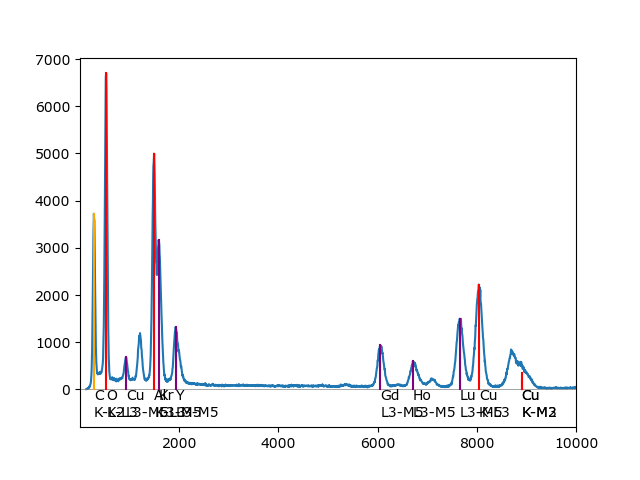

In [264]:
import pickle 
pkl_file = open('data/ffast.pkl', 'rb')
ffast = pickle.load(pkl_file)
pkl_file.close()

plt.figure()
#plt.plot(energy_scale1,spectrum2, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum')
plt.xlim(0.1,10000)
plt.ylim(-800)
plt.gca().axhline(y=0,color='gray',  linewidth = 0.5);

out_tags = {}
out_tags['spectra'] = {}

out_tags['spectra'][0] = {'data': spectrum,
                          'energy_scale': energy_scale,
                          'energy_scale_start': start,
                          'smooth_spectrum': new_spectrum,
                          'smooth_energy_scale': new_energy_scale,
                          'elements':{}
                         }
                          
for i in range(4,20):
    print(ffast[i]['lines']  )

#print(ffast[6])
number_of_elements = 0
for peak in minor_peaks:
    for element in range(1,93):
        if 'K-L3' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L3']['position']- new_energy_scale[peak]) <10:
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L3'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]
                number_of_elements += 1
                plt.plot([ffast[element]['lines']['K-L3']['position'],ffast[element]['lines']['K-L3']['position']], [0,new_spectrum[peak]], color = 'red')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L3', verticalalignment='top')
                for line in ffast[element]['lines']:
                    if 'K' in line:
                        if abs(ffast[element]['lines'][line]['position']-ffast[element]['lines']['K-L3']['position'])> 20:
                            if ffast[element]['lines'][line]['weight']>0.07:
                                #print(element, ffast[element]['lines'][line],new_spectrum[peak]*ffast[element]['lines'][line]['weight'])
                                plt.plot([ffast[element]['lines'][line]['position'],ffast[element]['lines'][line]['position']], [0,new_spectrum[peak]*ffast[element]['lines'][line]['weight']], color = 'red')
                                plt.text(ffast[element]['lines'][line]['position'],0, ffast[element]['element']+'\n'+line, verticalalignment='top')
                            
        elif 'K-L2' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L2']['position']- new_energy_scale[peak]) <10:
                plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'orange')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L2', verticalalignment='top')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L2'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]
                
                number_of_elements += 1
        if 'L3-M5' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['L3-M5']['position']- new_energy_scale[peak]) <10:
                pass
                print('found_element', element,ffast[element]['lines']['L3-M5']['position'], new_energy_scale[peak] )
                plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'purple')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nL3-M5', verticalalignment='top')
                
                #plt.scatter( new_energy_scale[peak], new_spectrum[peak], color = 'blue')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'L3-M5'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]
                
                number_of_elements += 1
for element in out_tags['spectra'][0]['elements']:                
    print(out_tags['spectra'][0]['elements'][element]['element'],out_tags['spectra'][0]['elements'][element]['found_lines'], out_tags['spectra'][0]['elements'][element]['experimental_peak_energy'])
    

In [247]:
out_tags

{'spectra': {0: {'data': sidpy.Dataset of type SPECTRUM with:
    dask.array<sum-aggregate, shape=(4096,), dtype=uint32, chunksize=(4096,), chunktype=numpy.ndarray>
    data contains: intensity (counts)
    and Dimensions: 
   energy_scale:  energy (eV) of size (4096,)
    with metadata: ['experiment', 'filename'],
   'energy_scale': energy_scale:  energy (eV) of size (4096,),
   'energy_scale_start': 75,
   'smooth_spectrum': array([ 5.,  7., 12., ..., 10.,  3.,  5.]),
   'smooth_energy_scale': energy_scale:  energy (eV) of size (4021,),
   'elements': {0: {'element': 'C',
     'found_lines': 'K-L2',
     'lines': {'K-L2': {'weight': 0.5, 'position': 277.40000000000003}},
     'experimental_peak_index': 31,
     'experimental_peak_energy': 280.0},
    1: {'element': 'O',
     'found_lines': 'K-L3',
     'lines': {'K-L3': {'weight': 1.0, 'position': 524.9},
      'K-L2': {'weight': 0.5, 'position': 524.9}},
     'experimental_peak_index': 81,
     'experimental_peak_energy': 530.0},
  

6 2e-07
0.0045


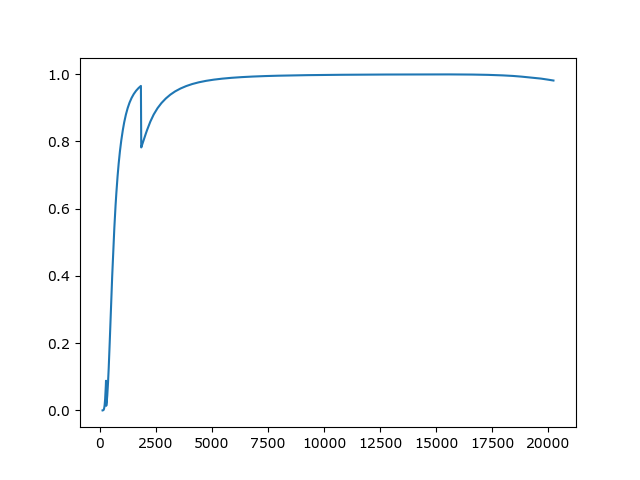

In [236]:



tags={'detector': { 'window': {'0': {'Z': 6,
                                     'thickness': 2 *1e-7}},
                   'SiDeadLayerThickness': .3,
                   'DetectorThickness':  45 * 1e-3}}

def detector_efficiency(tags, energy_scale):
    detector_Efficiency1 = np.ones(len(energy_scale))
    for key in tags['detector']['window']:
        Z = int(tags['detector']['window'][key]['Z'])
        if Z < 14:
            t = tags['detector']['window'][key]['thickness']

            ## interpolate mass absorption coefficient to our energy scale
            lin = interp1d(ffast[Z]['E'],ffast[Z]['photoabsorption'],kind='linear') 
            mu = lin(energy_scale) * ffast[Z]['nominal_density']*100. #1/cm -> 1/m
            detector_Efficiency1 = detector_Efficiency1 * np.exp(-mu * t)
            print(Z,t)
        
    t = float(tags['detector']['SiDeadLayerThickness'])*1e-6
    
    lin = interp1d(ffast[14]['E'],ffast[14]['photoabsorption'],kind='linear') 
    mu = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m
    detector_Efficiency1 = detector_Efficiency1 * np.exp(-mu * t)
    detector_thickness = float(tags['detector']['DetectorThickness'])*1e-1
    ## interpolate mass absorption coefficient to our energy scale
    mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m
    print(detector_thickness)
    
    detector_Efficiency2 = (1.0 - np.exp(-mu * detector_thickness))# * oo4pi;

    
    return detector_Efficiency1*detector_Efficiency2
detector_Efficiency = detector_efficiency(tags, new_energy_scale)    

plt.figure()
plt.plot(new_energy_scale, detector_Efficiency)

#plt.xlim(0,2000)

In [239]:


def model(p,energy_scale):
    E = energy_scale
    
    spectrum = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
    
    for i in range(5,len(p)):
        spectrum = spectrum+elements_peaks[i-5]*abs(p[i])
    return spectrum
def getFWHM(E):
    return np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)

def gaussian(enrgy_scale, mu, FWHM):
    sig = FWHM/2/np.sqrt(2*np.log(2))
    return np.exp(-np.power(enrgy_scale - mu, 2.) / (2 * np.power(sig, 2.)))
    

def getPeak(E, energy_scale):
    E_ref = 5895.0
    FWHM_ref = 136 #eV
    FWHM  = np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)
    return gaussian(energy_scale, E, FWHM)



    
p = [1, 37, .3, offset, scale]
E_0= 20
E = new_energy_scale
N = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)

pp = p[0:5].copy()
for i in range(len(elements_peaks)):
    pp.append(intensities[i])

    

spectrum3 = model(pp[:-1],new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.xlim(0,4)

NameError: name 'offset' is not defined

[1e-19, 9.7, 0.0003, 125, 0.5, 7446.000000000001, 4452.000000000001, 560.8404334518984, 3241.196013289037, 2822.1024258760112, 1180.5929919137468, 895.7518304279704, 548.0000000000001, 1452.0000000000002, 1260.1330913490626]


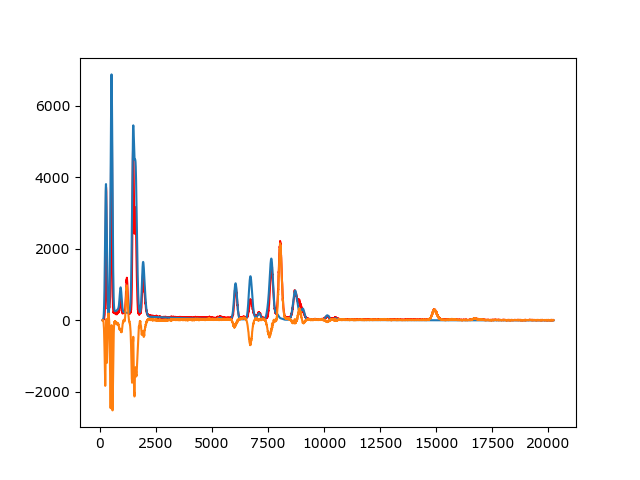

In [242]:


def model(p,energy_scale):
    E = energy_scale
    
    spectrum = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
    
    for i in range(5,len(p)):
        spectrum = spectrum+elements_peaks[i-5]*abs(p[i])
    return spectrum
def getFWHM(E):
    return np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)

def gaussian(enrgy_scale, mu, FWHM):
    sig = FWHM/2/np.sqrt(2*np.log(2))
    return np.exp(-np.power(enrgy_scale - mu, 2.) / (2 * np.power(sig, 2.)))

def getPeak(E, energy_scale):
    E_ref = 5895.0
    FWHM_ref = 150 #eV
    FWHM  = np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)
    return gaussian(energy_scale, E, FWHM)


Peaks = []
elements_peaks = []
intensities = []
for element in out_tags['spectra'][0]['elements']:
    el_dict = out_tags['spectra'][0]['elements'][element]
    
    position = el_dict['lines'][el_dict['found_lines']]['position']
    weight = 0
    for line in el_dict['lines']:
        if abs(position - el_dict['lines'][line]['position'])<20:
            weight += el_dict['lines'][line]['weight']
    index = np.searchsorted(new_energy_scale,el_dict['lines'][el_dict['found_lines']]['position'])  
    intensity = new_spectrum[index]/weight
    added_peaks = np.zeros(len(new_energy_scale))
    for line in el_dict['lines']: 
        if line[0] == el_dict['found_lines'][0]:
            if el_dict['lines'][line]['weight']> 0.01:
                p = getPeak(el_dict['lines'][line]['position'],new_energy_scale)*el_dict['lines'][line]['weight']
                Peaks.append(p)
                added_peaks = added_peaks + p 
    elements_peaks.append(added_peaks)        
    intensities.append(intensity)

    
p = [1e-19, 9.7, .0003, 125, .5]
E_0= 20e3
E = new_energy_scale
N = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)

pp = p[0:5].copy()
for i in range(len(elements_peaks)):
    pp.append(intensities[i])
print(pp)
    

spectrum3 = model(pp[:-1],new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
#plt.plot(new_energy_scale, detector_Efficiency * (p[0] + p[1]*(E_0-E)/E) + p[2]*(E_0-E)**2/E)
plt.plot(new_energy_scale, spectrum3)
plt.plot(new_energy_scale, new_spectrum-spectrum3)



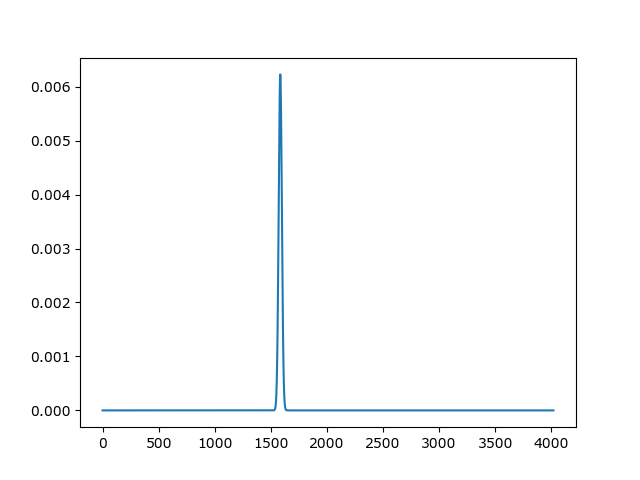

In [243]:
el_dict['lines']
p = getPeak(el_dict['lines']['K-L3']['position'],new_energy_scale)*el_dict['lines'][line]['weight']
plt.figure()
plt.plot(p)

In [244]:
print( f'element\t end   \t   start ')
for i, element in enumerate(out_tags['spectra'][0]['elements']):
    if i<len(p)-5:
        el_dict = out_tags['spectra'][0]['elements'][element]
        print(f"{el_dict['element']:2s}: \t  {abs(p[i+5]):6.2f} \t  {pp[i+5]:.2f}")
#print(p,pp)

element	 end   	   start 
C : 	    0.00 	  7446.00
O : 	    0.00 	  4452.00
Cu: 	    0.00 	  560.84
Al: 	    0.00 	  3241.20
Kr: 	    0.00 	  2822.10
Y : 	    0.00 	  1180.59
Gd: 	    0.00 	  895.75
Ho: 	    0.00 	  548.00
Lu: 	    0.00 	  1452.00
Cu: 	    0.00 	  1260.13


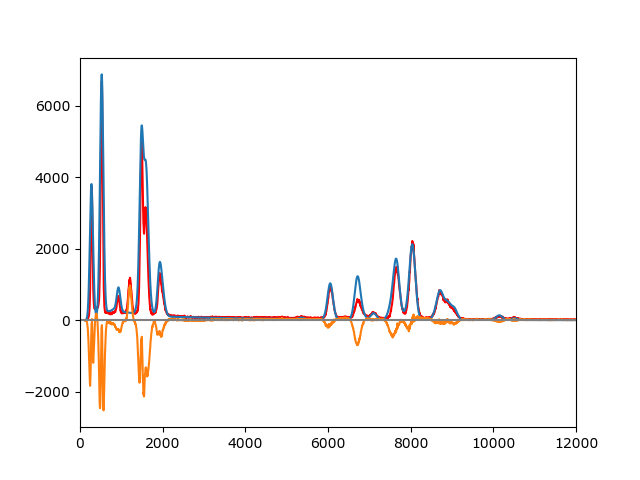

In [245]:
spectrum3 = model(pp,new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.plot(new_energy_scale, new_spectrum-spectrum3)
plt.gca().axhline(y=0,color='gray');


plt.xlim(0,12000);

In [227]:
print(pp)

[1e-09, 9.7, 0.0003, 125, 0.5, 7446.000000000001, 4452.000000000001, 560.8404334518984, 3241.196013289037, 2822.1024258760112, 1180.5929919137468, 895.7518304279704, 548.0000000000001, 1452.0000000000002, 1260.1330913490626]


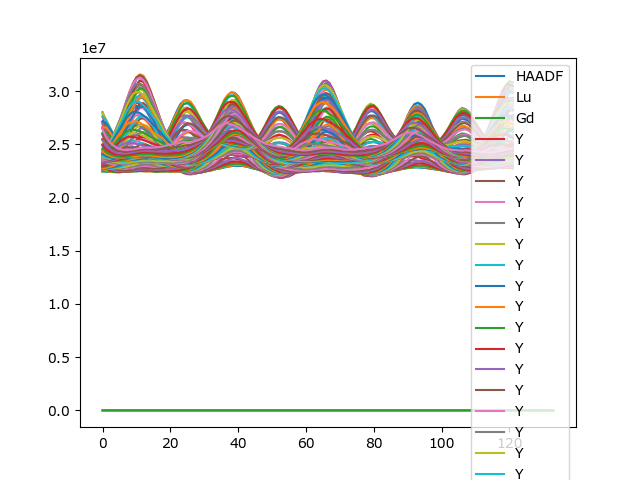

In [26]:
spec_hadf = dataset.sum(axis=0).sum(axis=0)
spec_Gd = datasets['Channel_000'].sum(axis=0)

spec_Lu = datasets['Channel_001'].sum(axis=0)
spec_Y = datasets['Channel_003'].sum(axis=0)
plt.figure()
plt.plot(spec_hadf/2e6, label='HAADF')
plt.plot(spec_Lu, label='Lu')
plt.plot(spec_Gd, label='Gd')
plt.plot(spec_Y, label='Y')
plt.legend()

In [41]:
E_ref = 5895.0
FWHM_ref = 128 #eV
E= 280 
def getFWHM(E):
    return np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)


print(f'C should have a line width of {getFWHM(E):.2f} eV')

C should have a line width of 48.44 eV


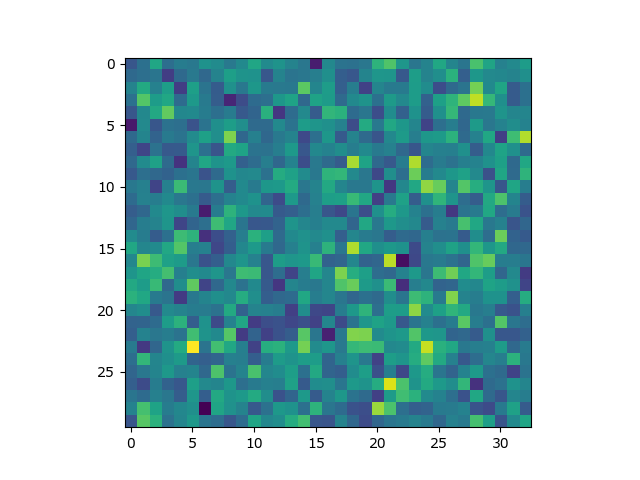

In [115]:
im = np.zeros([int(dataset.shape[0]/4), int(dataset.shape[1]/4)])
for x in range(int(dataset.shape[0]/4)):
    for y in range(int(dataset.shape[1]/4)):
        im[x,y] = dataset[x*4:x*4+4, y*4:y*4+4].sum()

plt.figure()
plt.imshow(im)

        

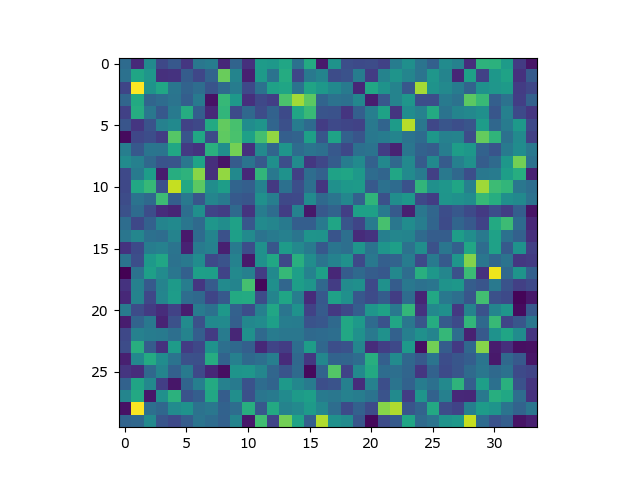

In [111]:
im = scipy.ndimage.zoom(dataset, 1/4)
im-=im.min()
plt.figure()
plt.imshow(im)


C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\sidpy\sid\dataset.py:1322: UserWarning: Dimensional information will be lost.                       Please use fold, unfold to combine dimensions
  warnings.warn('Dimensional information will be lost.\


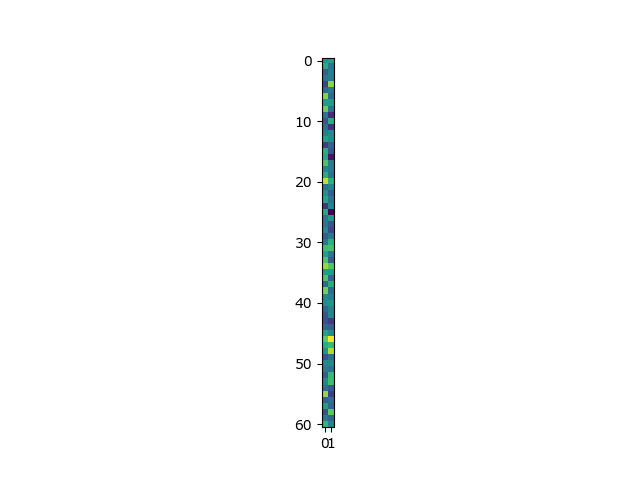

In [87]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1).sum(axis=1)

d = rebin(dataset, [int(dataset.shape[0]/2), int(dataset.shape[1]/2)])
plt.figure()
plt.imshow(np.array(d))

## Save File
let's save the datasets

In [29]:
h5_group = ft.save_dataset(datasets, filename=dataset.metadata['filename'])

Cannot overwrite file. Using:  STO-stack-1.hf5


C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_io.py:111: UserWarning: main_data_name should not contain the "-" character. Reformatted name from:Non-Rigid Registration to Non_Rigid Registration
  warn('main_data_name should not contain the "-" character. Reformatted'
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\AppData\Local\anaconda3\envs\pyTEMlib\Lib\site-packages\pyNSID\io\hdf_utils.py:376: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may 

In [30]:
print('original file ', dataset.metadata['filename'])
print('was saved to: '+ h5_group.file.filename)

original file  C:\Users\gduscher\Documents\Github\Image_Distortion\STO-stack.h5
was saved to: C:\Users\gduscher\Documents\Github\Image_Distortion\STO-stack-1.hf5


Please note, that the file is still open, so we need to close it.

In [31]:
h5_group.file.close()